['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite',

UsageError: Line magic function `%%time` not found.


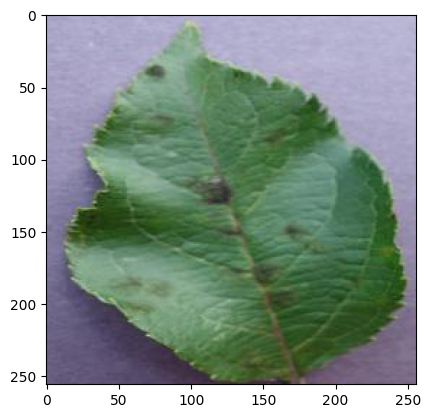

In [124]:
# ----------- + Full code starts from here + ----------- #

import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
from PIL import Image
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchsummary import summary
%matplotlib inline

## Data preprocessing step start

data_dir = "C:\\Users\\xlena\\OneDrive\\Desktop\\AI Project\\plant-data"
train_dir = data_dir + "\\train"
valid_dir = data_dir + "\\valid"
diseases = os.listdir(train_dir)


print(diseases)


print("Total disease classes are: {}".format(len(diseases)))


plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1
        
print()
# unique plants in the dataset
print(f"Unique Plants are: \n{plants}\n")

# number of unique plants
print("Number of plants: {}\n".format(len(plants)))

# number of unique diseases
print("Number of diseases: {}".format(NumberOfDiseases))

nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))

# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
print(img_per_class)


# Images available for training

n_train = 0
for value in nums.values():
    n_train += value
print(f"There are {n_train} images for training")


# datasets for validation and training
train = ImageFolder(train_dir, transform=transforms.ToTensor())
valid = ImageFolder(valid_dir, transform=transforms.ToTensor())

img, label = train[0]
print(img.shape, label)


print()

# total number of classes in train set
print(len(train.classes))


# for checking some images from training dataset
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))
    

show_image(*train[0])

# Setting the seed value
random_seed = 7
print("\n", torch.manual_seed(random_seed))

# setting the batch size
batch_size = 32

# DataLoaders for training and validation
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break
    
# Images for first batch of training
show_batch(train_dl)

## Data preprocessing step end

## Hardware preperation for CPU usage start

def get_default_device():
    return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device='cpu'):
    """Move tensor(s) to the specified device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader:
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device='cpu'):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    
    
device = get_default_device()
print("\n", device)

# Moving data into GPU
train_dl = DeviceDataLoader(train_dl, device='cpu')
valid_dl = DeviceDataLoader(valid_dl, device='cpu')


## Hardware preperation for CPU usage end

## Simple Residual Block start

class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

## Simple Residual Block end

# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))



## base class for the model start
class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))


# Architecture for training

# convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


# resnet architecture
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()

        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # out_dim : 128 x 64 x 64
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))

        self.conv3 = ConvBlock(128, 256, pool=True) # out_dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # out_dim : 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4), nn.Flatten(), nn.Linear(512, num_diseases))

    def forward(self, xb): # xb is the loaded batch
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

model = to_device(ResNet9(3, len(train.classes)), device='cpu')
model = model.to('cpu')
print(model)


INPUT_SHAPE = (3, 256, 256)

# for training
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# lr: learning rate
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    #torch.cuda.empty_cache()
    history = []

    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # scheduler for one cycle learniing rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))


    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()


        # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

    return history


In [125]:
%%time
# Evaluating the model
history = [evaluate(model, valid_dl)]

CPU times: total: 42min 46s
Wall time: 9min 17s


In [126]:
epochs = 2
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [127]:
%%time
history += fit_OneCycle(epochs, max_lr, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=1e-4,
                             opt_func=opt_func)


Epoch [0], last_lr: 0.00812, train_loss: 0.7261, val_loss: 0.3168, val_acc: 0.9051
Epoch [1], last_lr: 0.00000, train_loss: 0.1226, val_loss: 0.0269, val_acc: 0.9923
CPU times: total: 18h 33min 19s
Wall time: 4h 3min 58s


In [128]:
def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')


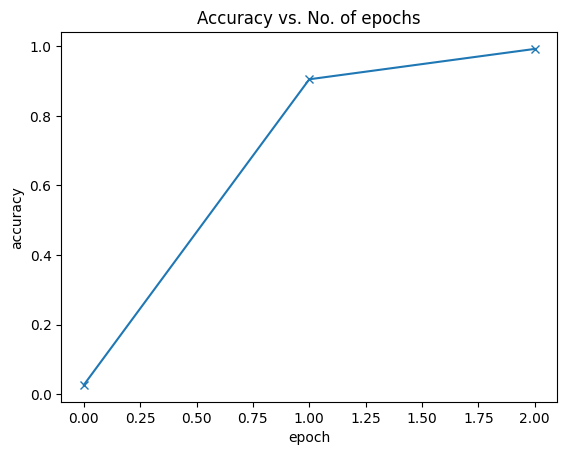

In [129]:
plot_accuracies(history)

In [130]:
test_dir = "C:\\Users\\xlena\\OneDrive\\Desktop\\AI Project\\plant-data\\test"
test = ImageFolder(test_dir, transform=transforms.ToTensor())

In [131]:
test_images = sorted(os.listdir(test_dir + '\\test')) # since images in test folder are in alphabetical order
test_images

['AppleCedarRust1.JPG',
 'AppleCedarRust2.JPG',
 'AppleCedarRust3.JPG',
 'AppleCedarRust4.JPG',
 'AppleScab1.JPG',
 'AppleScab2.JPG',
 'AppleScab3.JPG',
 'CornCommonRust1.JPG',
 'CornCommonRust2.JPG',
 'CornCommonRust3.JPG',
 'PotatoEarlyBlight1.JPG',
 'PotatoEarlyBlight2.JPG',
 'PotatoEarlyBlight3.JPG',
 'PotatoEarlyBlight4.JPG',
 'PotatoEarlyBlight5.JPG',
 'PotatoHealthy1.JPG',
 'PotatoHealthy2.JPG',
 'TomatoEarlyBlight1.JPG',
 'TomatoEarlyBlight2.JPG',
 'TomatoEarlyBlight3.JPG',
 'TomatoEarlyBlight4.JPG',
 'TomatoEarlyBlight5.JPG',
 'TomatoEarlyBlight6.JPG',
 'TomatoHealthy1.JPG',
 'TomatoHealthy2.JPG',
 'TomatoHealthy3.JPG',
 'TomatoHealthy4.JPG',
 'TomatoYellowCurlVirus1.JPG',
 'TomatoYellowCurlVirus2.JPG',
 'TomatoYellowCurlVirus3.JPG',
 'TomatoYellowCurlVirus4.JPG',
 'TomatoYellowCurlVirus5.JPG',
 'TomatoYellowCurlVirus6.JPG']

In [133]:
def predict_image(img, model):
    """Converts image to array and return the predicted class
        with highest probability"""
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label

    return train.classes[preds[0].item()]

Label: AppleCedarRust1.JPG , Predicted: Apple___Cedar_apple_rust


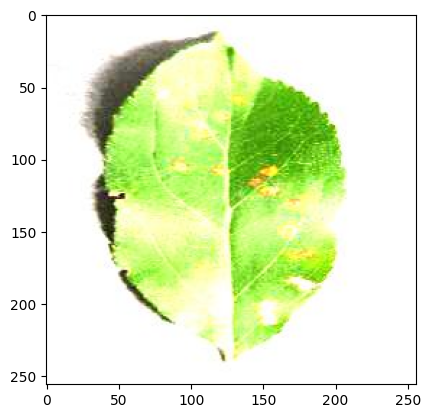

In [134]:
# predicting first image
img, label = test[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_images[0], ', Predicted:', predict_image(img, model))

In [135]:
# getting all predictions (actual label vs predicted)
for i, (img, label) in enumerate(test):
    print('Label:', test_images[i], ', Predicted:', predict_image(img, model))

Label: AppleCedarRust1.JPG , Predicted: Apple___Cedar_apple_rust
Label: AppleCedarRust2.JPG , Predicted: Apple___Cedar_apple_rust
Label: AppleCedarRust3.JPG , Predicted: Apple___Cedar_apple_rust
Label: AppleCedarRust4.JPG , Predicted: Apple___Cedar_apple_rust
Label: AppleScab1.JPG , Predicted: Apple___Apple_scab
Label: AppleScab2.JPG , Predicted: Apple___Apple_scab
Label: AppleScab3.JPG , Predicted: Apple___Apple_scab
Label: CornCommonRust1.JPG , Predicted: Corn_(maize)___Common_rust_
Label: CornCommonRust2.JPG , Predicted: Corn_(maize)___Common_rust_
Label: CornCommonRust3.JPG , Predicted: Corn_(maize)___Common_rust_
Label: PotatoEarlyBlight1.JPG , Predicted: Potato___Early_blight
Label: PotatoEarlyBlight2.JPG , Predicted: Potato___Early_blight
Label: PotatoEarlyBlight3.JPG , Predicted: Potato___Early_blight
Label: PotatoEarlyBlight4.JPG , Predicted: Potato___Early_blight
Label: PotatoEarlyBlight5.JPG , Predicted: Potato___Early_blight
Label: PotatoHealthy1.JPG , Predicted: Potato___h

In [137]:
# saving to the working directory
PATH = 'C:\\Users\\xlena\\OneDrive\\Desktop\\AI Project\\model.pth'  
torch.save(model.state_dict(), PATH)